**Trabajo realizado por Miguel Ángel Roldán Carmona**
# Introducción

[Bank-marketing](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&id=1461) es un conjunto de datos relacionado con las campañas de marketing llevadas a cabo por una institución bancaria de Portugal. Las campañas de marketing se llevaron a cabo mediante llamadas telefónicas. A menudo, se requería más de un contacto con el mismo cliente para acceder a si el producto (depósito bancario a plazo) sería (o no) suscrito.

Atributos del conjunto de datos:
* Datos del cliente.
    1. age - edad del cliente.
    2. job - tipo de profesión ("admin.","unknown","unemployed","management","housemaid","entrepreneur", "student","blue-collar","self-employed","retired","technician","services").
    3. marital - estado marital ("married","divorced","single"; nota: "divorced" significa divorciado o viudo).
    4. education - ("unknown","secondary","primary","tertiary").
    5. default - ¿tiene crédito en default? ("yes","no").
    6. balance - balance medio anual, en euros.
    7. housing - ¿tiene una  hipoteca? ("yes","no").
    8. loan - ¿tiene un préstamo? ("yes","no").

* Datos relacionados con el último contacto de la campaña actual.

    9. contact - tipo de comunicación del contacto (categorical: "unknown","telephone","cellular").
    10. day - último día de contacto ("mon","tue","wed","thu","fri").
    11. month - último mes de contacto ("jan", "feb", "mar", ..., "nov", "dec").
    12. duration - duración del último contacto, en segundos (e.g., si duration=0, entonces y="no"). Aún así, la duración no se conoce antes de realizar la llamada. De forma similar, al finalizar la llamada y es conocida. Por tanto, esta variable debería ser excluida para realizar modelos predicitivos realísticos.

* Otros atributos.

    13. campaign - número de contactos llevados a cabo durante la campaña para este cliente.
    14. pdays - número de dias pasados después del último día que se contactó con el cliente para una campaña anterior (-1 significa que el cliente nunca ha sido contactado).
    15. previous - número de contactos llevados a cabo antes de esta campaña para este cliente.
    16. poutcome - resultado de la anterior campaña de marketing ("unknown","other","failure","success").
* Variable de salida.

    17. y - ¿el cliente se suscribió a un depósito bancario a plazo? ("yes","no").

# Preparación de los datos

In [94]:
library(arules)
library(arulesViz)
library(colorspace)
library(tidyverse)
bank <- read_delim('bank-full.csv', delim = ';')
bank <- bank[complete.cases(bank),] # Nos quedamos solo con las filas completas
dim(bank)
bank[1:2,]

Rows: 45211 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (10): job, marital, education, default, housing, loan, contact, month, p...
dbl  (7): age, balance, day, duration, campaign, pdays, previous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 45211    17

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


El conjunto de datos contiene 45211 instancias y 17 atributos/variables, de los cuales 6 son atributos numéricos. Vemos que los atributos categóricos se han guardado como caracteres y no por sus valores. Primero arreglamos los atributos categóricos.

In [2]:
bank$job <- factor(bank$job)
bank$marital <- factor(bank$marital)
bank$education <- factor(bank$education)
bank$default <- factor(bank$default)
bank$housing <- factor(bank$housing)
bank$loan <- factor(bank$loan)
bank$contact <- factor(bank$contact)
bank$day <- factor(bank$day, levels = 1:5, labels = c("mon","tue","wed","thu","fri"))
bank$month <- factor(bank$month)
bank$poutcome <- factor(bank$poutcome)
bank$y <- factor(bank$y)

Comprobamos que se han separado por sus valores de forma correcta.

In [3]:
head(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
58,management,married,tertiary,no,2143,yes,no,unknown,fri,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,fri,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,fri,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,fri,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,fri,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,fri,may,139,1,-1,0,unknown,no


## Estudio de los atributos numéricos

Para establecer la separación de los atributos numéricos obtenemos el resumen de los datos y los representamos de forma gráfica.

In [4]:
summary(bank)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   divorced: 5207   primary  : 6851  
 1st Qu.:33.00   management :9458   married :27214   secondary:23202  
 Median :39.00   technician :7597   single  :12790   tertiary :13301  
 Mean   :40.94   admin.     :5171                    unknown  : 1857  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   no :20081   no :37967   cellular :29285  
 yes:  815   1st Qu.:    72   yes:25130   yes: 7244   telephone: 2906  
             Median :   448                           unknown  :13020  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


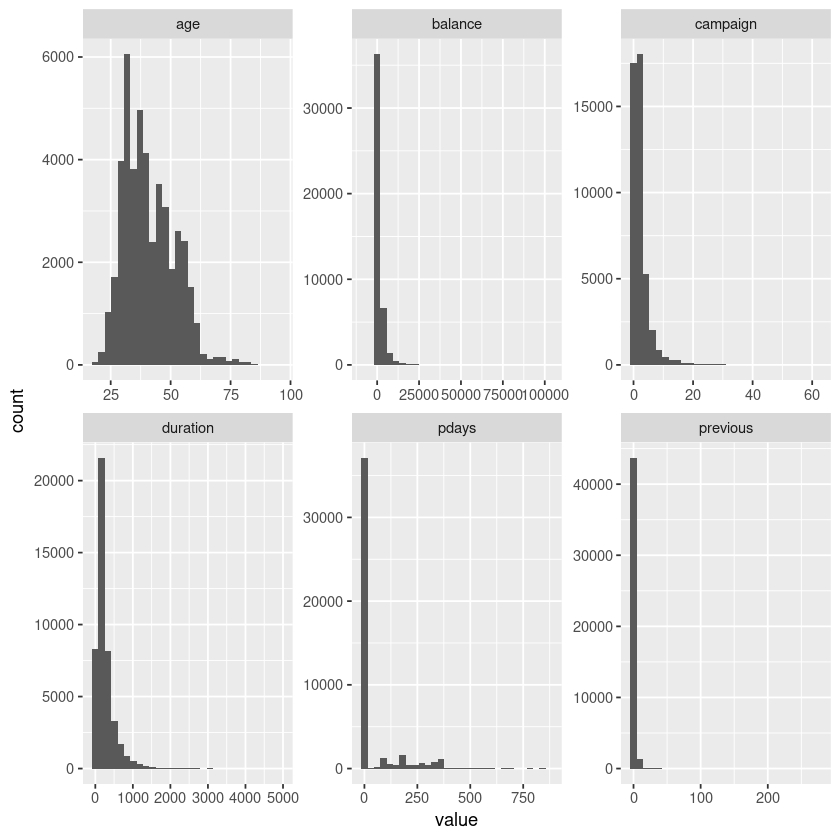

In [5]:
bank %>%
  select_if(is.numeric) %>%
  gather(cols, value) %>%
  ggplot(aes(x = value)) +
  geom_histogram() +
  facet_wrap(~ cols, scales = "free")

**Intervalos elegidos:**
* Age: lo cortamos en los niveles Young (18-33], Middle-Aged (33-50] y Senior (50+).
* Balance: lo cortamos en los niveles Negative (< 0), Below-average (0,1362] y Above-average (1362+).
* Campaign: lo cortamos en los niveles One (1), Two (2), Many [3+).
* Duration: lo cortamos en los niveles Quick (0,120], Regular (120,300] y Long (300+).
* Pdays: lo cortamos en los niveles Never (-1), Month [0,30), Quarterly [30,180), Old(+180).
* Previous: lo cortamos en los niveles Never (0), One(1), Two(2) y More (+2).

In [6]:
bank[["age"]] <- ordered(cut(bank[["age"]], c(18,33,50,95), labels = c("young","middle-aged", "senior")))
bank[["balance"]] <- ordered(cut(bank[["balance"]], c(-Inf,0,1362,Inf), labels = c("negative","below-avg","above-avg")))
bank[["campaign"]] <- ordered(cut(bank[["campaign"]], c(0,2,3,Inf), labels = c("one","two","many")))
bank[["duration"]] <- ordered(cut(bank[["duration"]], c(0,120,300,Inf), labels = c("quick","regular","long")))
bank[["pdays"]] <- ordered(cut(bank[["pdays"]], c(-Inf,0,30,180,Inf), labels = c("never","month","quaterly","old")))
bank[["previous"]] <- ordered(cut(bank[["previous"]],c(-Inf,0,1,2,Inf), labels = c("never","one","two","more")))

Comprobamos que los datos se han guardado de forma correcta.

In [7]:
head(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<ord>,<fct>,<fct>,<fct>,<fct>,<ord>,<fct>,<fct>,<fct>,<fct>,<fct>,<ord>,<ord>,<ord>,<ord>,<fct>,<fct>
senior,management,married,tertiary,no,above-avg,yes,no,unknown,fri,may,regular,one,never,never,unknown,no
middle-aged,technician,single,secondary,no,below-avg,yes,no,unknown,fri,may,regular,one,never,never,unknown,no
young,entrepreneur,married,secondary,no,below-avg,yes,yes,unknown,fri,may,quick,one,never,never,unknown,no
middle-aged,blue-collar,married,unknown,no,above-avg,yes,no,unknown,fri,may,quick,one,never,never,unknown,no
young,unknown,single,unknown,no,below-avg,no,no,unknown,fri,may,regular,one,never,never,unknown,no
middle-aged,management,married,tertiary,no,below-avg,yes,no,unknown,fri,may,regular,one,never,never,unknown,no


# Obtención de información de la base de datos

Vemos un resumen del conjunto de transacciones.

In [8]:
Bank <- as(bank,"transactions")
summary(Bank)

transactions as itemMatrix in sparse format with
 45211 rows (elements/itemsets/transactions) and
 71 columns (items) and a density of 0.2272319 

most frequent items:
      default=no             y=no          loan=no poutcome=unknown 
           44396            39922            37967            36959 
     pdays=never          (Other) 
           36954           533212 

element (itemset/transaction) length distribution:
sizes
   15    16    17 
   12 39153  6046 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   16.00   16.00   16.13   16.00   17.00 

includes extended item information - examples:
           labels variables      levels
1       age=young       age       young
2 age=middle-aged       age middle-aged
3      age=senior       age      senior

includes extended transaction information - examples:
  transactionID
1             1
2             2
3             3

Observamos varios ítems que se cumplen para la mayoría de clientes:
* default=no - según la wikipedia, "un impago o default es el incumplimiento de las obligaciones legales o condiciones de un préstamo". En el sentido del problema, la mayoría de clientes no son fraudulentos. 
* y=no - los clientes no se suscribieron a un depósito bancario a plazos.
* loan=no - no poseían un préstamo cuando se realizó la campaña de marketing.
* poutcome=unknown - no se conoce o no se tiene registro del resultado de la campaña anterior con el cliente.
* pdays=never - nunca se había contactado con el cliente para realizarle una oferta de marketing.

Gracias a estos ítems establecemos el perfil promedio del cliente: son clientes no fraudulentos, sin préstamos y a los cuales nunca se les había ofrecido una campaña de marketing o no se había seguido registro del resultado. 

Por otro lado, podemos decir que la campaña obtuvo un rendimiento del 12%, donde aproximadamente uno de cada diez clientes se suscribió al producto.

Como en el conjunto Bank cada transacción tiene un valor cada atributo/variable, no se puede representar gráficamente la distribución de los ítems en las transacciones, como se aprecia en la siguiente figura.

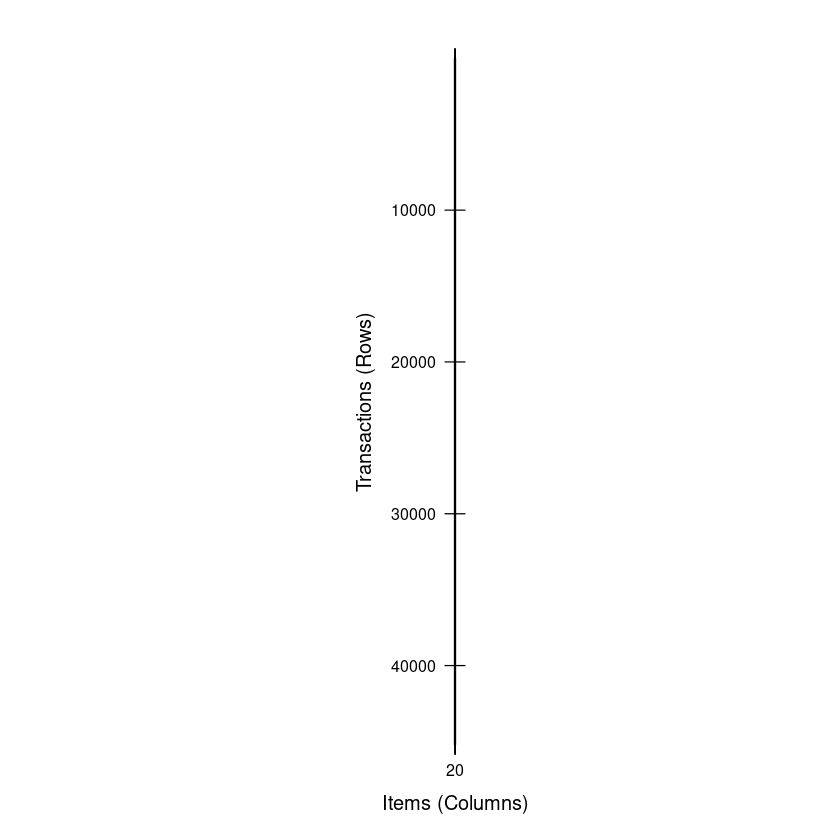

In [9]:
image(Bank)

## Items frecuentes

Representamos de forma gráfica los ítems más frecuentes del conjunto de transacciones para extraer más información sobre los atributos.

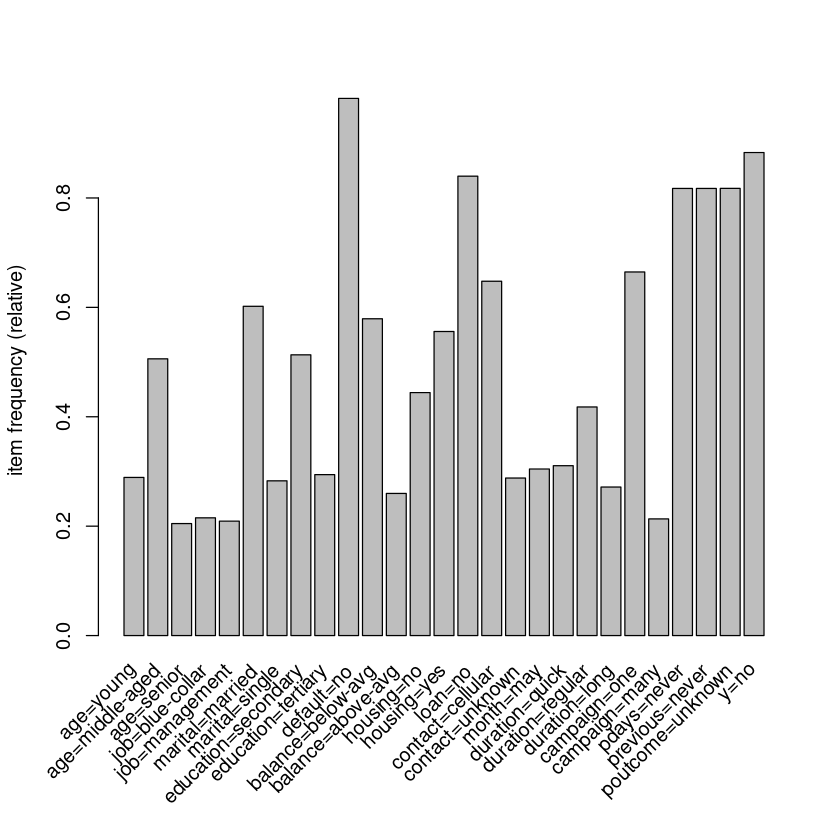

In [10]:
itemFrequencyPlot(Bank, support=0.2)

Este gráfico nos muestra algunos datos interesantes sobre la campaña:
* Más del 50% de los clientes estaban casados.
* Más del 50% de los clientes tenía una hipoteca.
* Más del 50% de los contactos con los clientes se hicieron a través de forma cellular.
* La tendencia de duración indica que las comunicaciones duraban menos de cinco minutos.

## Itemsets frecuentes

Para obtener los itemsets frecuentes aplicamos el método a priori sobre el conjunto de transacciones y los ordenamos por el soporte. Nos quedamos con los diez primeros elementos de la lista para ver los itemsets más frecuentes.

In [11]:
iBank <- apriori(Bank, parameter=list(support=0.1, target="frequent"))
iBank <- sort(iBank, by="support")
inspect(head(iBank, n=10))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
         NA    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen            target  ext
     10 frequent itemsets TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4521 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[71 item(s), 45211 transaction(s)] done [0.05s].
sorting and recoding items ... [40 item(s)] done [0.01s].
creating transaction tree ... done [0.03s].
checking subsets of size 1 2 3 4 5 6 7 8 9 done [0.58s].
sorting transactions ... done [0.02s].
writing ... [12264 set(s)] done [0.00s].
creating S4 object  ... done [0.01s].
     items                           support   count
[1]  {default=no}                    0.9819734 44396
[2]  {y=no}                          0.8830152 39922
[3]  {default=no, y=no}              0.8661388 39159


En este caso observamos los itemsets más frecuentes, donde se cumplen reglas generales con un soporte mayor al 80%. A parte de los itemsets de tamaño igual a uno que ya hemos visto, podemos destacar los siguientes:
* {default=no, loan=no} - los clientes que no tienen crédito en default tampoco poseen un préstamo.
* {pdays=never, previous=never} - los clientes que no se les había contactado antes no podían tener un contador de días previos.

Inspeccionamos los itemsets de tamaño igual a uno para ver otros valores que nos puedan aportar información acerca del problema.

In [12]:
inspect(iBank[size(iBank) == 1])

     items                 support   count
[1]  {default=no}          0.9819734 44396
[2]  {y=no}                0.8830152 39922
[3]  {loan=no}             0.8397735 37967
[4]  {poutcome=unknown}    0.8174780 36959
[5]  {pdays=never}         0.8173675 36954
[6]  {previous=never}      0.8173675 36954
[7]  {campaign=one}        0.6646391 30049
[8]  {contact=cellular}    0.6477406 29285
[9]  {marital=married}     0.6019332 27214
[10] {balance=below-avg}   0.5791290 26183
[11] {housing=yes}         0.5558382 25130
[12] {education=secondary} 0.5131937 23202
[13] {age=middle-aged}     0.5059167 22873
[14] {housing=no}          0.4441618 20081
[15] {duration=regular}    0.4178850 18893
[16] {duration=quick}      0.3105660 14041
[17] {month=may}           0.3044834 13766
[18] {education=tertiary}  0.2941983 13301
[19] {age=young}           0.2891111 13071
[20] {contact=unknown}     0.2879830 13020
[21] {marital=single}      0.2828958 12790
[22] {duration=long}       0.2714826 12274
[23] {balan

Vemos que los meses más intensos de la campaña fueron mayo, junio, julio y agosto. Esto puede indicar que el despliegue principal de la campaña se realizó en esos meses. También observamos que los clientes se contactaban una vez o varias, lo que puede indicar que los clientes que no contrataban el producto solo eran comunicados una vez y a los clientes que eran más propensos a contratar el producto eran contactados varias veces.

Representamos el número de itemsets por tamaño para ver la distribución.

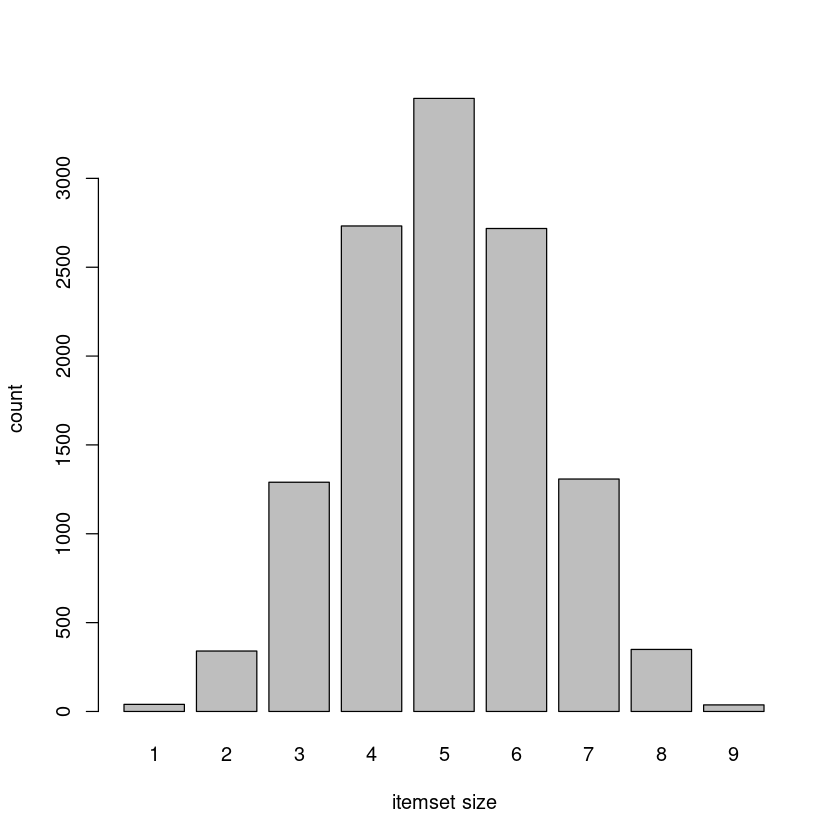

In [13]:
barplot(table(size(iBank)), xlab="itemset size", ylab="count")

Obtenemos que los itemsets de tamaño igual a cinco son los más comunes, existiendo más de 2500 itemsets. Como tenemos una gran cantidad de itemsets, nos quedamos solo con los itemsets maximales y mostramos los 6 primeros ordenados por su valor de soporte.

In [14]:
imaxBank <- iBank[is.maximal(iBank)]
inspect(head(sort(imaxBank, by="support")))

    items                  support count
[1] {default=no,                        
     loan=no,                           
     contact=cellular,                  
     duration=regular,                  
     pdays=never,                       
     previous=never,                    
     poutcome=unknown,                  
     y=no}               0.1457831  6591
[2] {default=no,                        
     loan=no,                           
     campaign=many,                     
     pdays=never,                       
     previous=never,                    
     poutcome=unknown,                  
     y=no}               0.1448320  6548
[3] {marital=married,                   
     default=no,                        
     loan=no,                           
     contact=unknown,                   
     pdays=never,                       
     previous=never,                    
     poutcome=unknown,                  
     y=no}               0.1403198  6344
[4] {default=no,

Los itemsets maximales son aquellos conjuntos frecuentes para los que ninguno de sus superconjuntos inmediatos son frecuentes. No encontramos itemsets que nos aporten más información acerca del problema.

De forma similar a los itemsets maximales, extraemos los primeros 10 itemsets cerrados.

In [15]:
icloBank <- iBank[is.closed(iBank)]
inspect(head(sort(icloBank, by="support"), n=10))

     items                 support count
[1]  {default=no}        0.9819734 44396
[2]  {y=no}              0.8830152 39922
[3]  {default=no,                       
      y=no}              0.8661388 39159
[4]  {loan=no}           0.8397735 37967
[5]  {default=no,                       
      loan=no}           0.8284046 37453
[6]  {poutcome=unknown}  0.8174780 36959
[7]  {pdays=never,                      
      previous=never,                   
      poutcome=unknown}  0.8173675 36954
[8]  {default=no,                       
      poutcome=unknown}  0.8007122 36201
[9]  {default=no,                       
      pdays=never,                      
      previous=never,                   
      poutcome=unknown}  0.8006016 36196
[10] {poutcome=unknown,                 
      y=no}              0.7425848 33573


En los itemsets cerrados obtenemos los mismos itemsets que habíamos obtenido al obtener los itemsets frecuentes utilizando el método a priori.

También podemos ver de forma gráfica la cantidad de itemsets frecuentes, cerrados y maximales que se han obtenido.

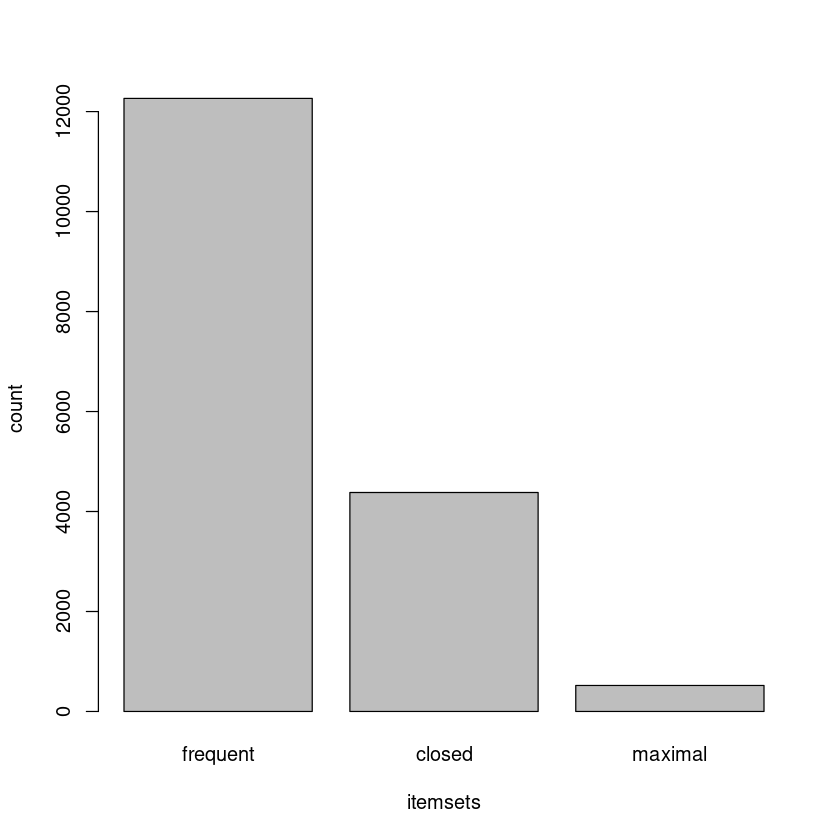

In [16]:
barplot(c(frequent=length(iBank), closed=length(icloBank), maximal=length(imaxBank)), ylab="count", xlab="itemsets")

## Conclusiones iniciales

En este apartado hemos obtenido información general sobre el dominio del problema, donde hemos visto el perfil promedio del cliente, el rendimiento de la campaña y los meses principales en los que se llevó a cabo (mayo, junio, julio y agosto), así como las reglas generales. Una vez hemos obtenido la información principal, podemos centrarnos en la exploración de reglas que estan más ocultas y aportan valor a la información.

# Extracción de reglas

Usamos el método a priori para extraer las reglas con mínimo soporte 0.1 y confianza 0.8. También indicamos que al menos la longitud de las reglas sea 2 (antecedente y consecuente).

In [17]:
rules <- apriori(Bank, parameter=list(support=0.1, confidence=0.8, minlen=2))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 4521 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[71 item(s), 45211 transaction(s)] done [0.05s].
sorting and recoding items ... [40 item(s)] done [0.01s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 8 9 done [0.56s].
writing ... [32720 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


Con este soporte obtenemos reglas muy generales que aparecen al menos en 4521 transacciones.

Obtenemos información resumida del conjunto de reglas obtenido.

In [18]:
summary(rules)

set of 32720 rules

rule length distribution (lhs + rhs):sizes
   2    3    4    5    6    7    8    9 
 201 1457 4914 8958 9433 5714 1820  223 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   5.000   6.000   5.574   6.000   9.000 

summary of quality measures:
    support         confidence        coverage           lift       
 Min.   :0.1000   Min.   :0.8000   Min.   :0.1000   Min.   :0.9064  
 1st Qu.:0.1132   1st Qu.:0.8842   1st Qu.:0.1208   1st Qu.:1.0011  
 Median :0.1318   Median :0.9840   Median :0.1420   Median :1.0646  
 Mean   :0.1603   Mean   :0.9448   Mean   :0.1708   Mean   :1.1163  
 3rd Qu.:0.1760   3rd Qu.:1.0000   3rd Qu.:0.1883   3rd Qu.:1.2233  
 Max.   :0.8661   Max.   :1.0000   Max.   :0.9820   Max.   :3.1293  
     count      
 Min.   : 4522  
 1st Qu.: 5117  
 Median : 5961  
 Mean   : 7247  
 3rd Qu.: 7955  
 Max.   :39159  

mining info:
 data ntransactions support confidence
 Bank         45211     0.1        0.8
                                

El primer cuartil para el tamaño de las reglas se sitúa en 5, lo que indica que más del 75% de las reglas obtenidas tienen un tamaño igual o mayor a 5. Las medidas de calidad nos indican que el soporte de las reglas es bajo teniendo un tercer cuartil por debajo del 0.2, pero son reglas con una confianza muy alta teniendo una media de 0.945.

Vemos algunas de las reglas obtenidas.

In [19]:
inspect(head(rules))

    lhs                   rhs                support   confidence coverage 
[1] {poutcome=failure} => {contact=cellular} 0.1001747 0.9240971  0.1084028
[2] {poutcome=failure} => {default=no}       0.1075402 0.9920424  0.1084028
[3] {pdays=old}        => {contact=cellular} 0.1027184 0.9179680  0.1118975
[4] {pdays=old}        => {default=no}       0.1108801 0.9909073  0.1118975
[5] {job=admin.}       => {y=no}             0.1004180 0.8779733  0.1143748
[6] {job=admin.}       => {default=no}       0.1127381 0.9856894  0.1143748
    lift      count
[1] 1.4266469 4529 
[2] 1.0102539 4862 
[3] 1.4171846 4644 
[4] 1.0090979 5013 
[5] 0.9942902 4540 
[6] 1.0037842 5097 


Aqui podemos ver algunas reglas contradictorias: no se puede saber que el contacto a través del celular va a ser fallido antes de que pase. Sin embargo, ya encontramos algunas reglas con mayor valor donde los clientes que trabajan de admin. no contrataban el producto con una confianza del 98%.

# Estudio de reglas deseadas

En este apartado vamos a crear un conjunto de reglas con un soporte menor al inicial con el objetivo de encontrar reglas interesantes que no son tan comunes en el conjunto de transacciones.

In [20]:
rules <- apriori(Bank, parameter=list(support=0.01, confidence=0.8, minlen=2))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5    0.01      2
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 452 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[71 item(s), 45211 transaction(s)] done [0.05s].
sorting and recoding items ... [67 item(s)] done [0.01s].
creating transaction tree ... done [0.03s].
checking subsets of size 1 2 3 4 5 6 7 8

Warning message in apriori(Bank, parameter = list(support = 0.01, confidence = 0.8, :
“Mining stopped (time limit reached). Only patterns up to a length of 8 returned!”


 done [5.07s].
writing ... [1498511 rule(s)] done [0.27s].
creating S4 object  ... done [0.49s].


In [21]:
summary(rules)

set of 1498511 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5      6      7      8 
   322   5644  39830 147808 334546 491511 478850 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   6.000   7.000   6.803   8.000   8.000 

summary of quality measures:
    support          confidence        coverage            lift       
 Min.   :0.01002   Min.   :0.8000   Min.   :0.01002   Min.   :0.8283  
 1st Qu.:0.01254   1st Qu.:0.8930   1st Qu.:0.01332   1st Qu.:1.0106  
 Median :0.01694   Median :0.9833   Median :0.01798   Median :1.1271  
 Mean   :0.02538   Mean   :0.9463   Mean   :0.02697   Mean   :1.1834  
 3rd Qu.:0.02694   3rd Qu.:1.0000   3rd Qu.:0.02860   3rd Qu.:1.2234  
 Max.   :0.86614   Max.   :1.0000   Max.   :0.98197   Max.   :7.8967  
     count      
 Min.   :  453  
 1st Qu.:  567  
 Median :  766  
 Mean   : 1148  
 3rd Qu.: 1218  
 Max.   :39159  

mining info:
 data ntransactions support confidence
 Bank         45211    0.01        0.

Al reducir el soporte vemos que obtenemos un número muy elevado de reglas. Inspeccionamos la cabecera de reglas ordenadas por confianza para ver que reglas se cumplen más a menudo.

In [44]:
rulesSorted <- sort(rules, by="confidence")
inspect(head(rulesSorted, n=10))

     lhs                              rhs                support    confidence
[1]  {month=mar}                   => {default=no}       0.01055053 1         
[2]  {month=oct}                   => {default=no}       0.01632346 1         
[3]  {pdays=never}                 => {previous=never}   0.81736745 1         
[4]  {previous=never}              => {pdays=never}      0.81736745 1         
[5]  {pdays=never}                 => {poutcome=unknown} 0.81736745 1         
[6]  {previous=never}              => {poutcome=unknown} 0.81736745 1         
[7]  {month=sep, campaign=one}     => {default=no}       0.01063900 1         
[8]  {housing=no, month=oct}       => {default=no}       0.01262967 1         
[9]  {contact=cellular, month=oct} => {default=no}       0.01232001 1         
[10] {month=oct, campaign=one}     => {default=no}       0.01435491 1         
     coverage   lift     count
[1]  0.01055053 1.018358   477
[2]  0.01632346 1.018358   738
[3]  0.81736745 1.223440 36954
[4]  0.

Eliminamos las reglas redundantes y volvemos a ordenar.

In [28]:
redundant <- is.redundant(x=rulesSorted, measure="confidence")
rulesPruned <- rulesSorted[!redundant]
summary(rulesPruned)

set of 42834 rules

rule length distribution (lhs + rhs):sizes
    2     3     4     5     6     7     8 
  322  2152  7604 12320 11453  6662  2321 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    5.00    5.00    5.44    6.00    8.00 

summary of quality measures:
    support          confidence        coverage            lift       
 Min.   :0.01002   Min.   :0.8000   Min.   :0.01004   Min.   :0.9096  
 1st Qu.:0.01263   1st Qu.:0.8739   1st Qu.:0.01369   1st Qu.:1.0446  
 Median :0.01716   Median :0.9412   Median :0.01858   Median :1.1172  
 Mean   :0.02868   Mean   :0.9270   Mean   :0.03105   Mean   :1.3379  
 3rd Qu.:0.02858   3rd Qu.:0.9872   3rd Qu.:0.03103   3rd Qu.:1.4100  
 Max.   :0.86614   Max.   :1.0000   Max.   :0.98197   Max.   :7.8967  
     count      
 Min.   :  453  
 1st Qu.:  571  
 Median :  776  
 Mean   : 1296  
 3rd Qu.: 1292  
 Max.   :39159  

mining info:
 data ntransactions support confidence
 Bank         45211    0.01        0.8
              

Podemos observar que elimina un gran número de reglas redundantes pasando de tener 1498511 reglas a 42834, lo que supone eliminar aproximadamente el 97% de las reglas obtenidas con el método apriori.

## Visualización de las reglas

En un gráfico de grafos podemos ver la relación entre los valores de las variables y el soporte que tienen dentro del conjunto de transacciones. En el siguiente grafo vemos que los valores más relacionados son previous=never, pdays=never y poutcome=unknown. La razón principal de su relación es que son los que mejor reflejan el caso de nuevos clientes y procesos que no se han sido terminados.

También podemos ver algunos valores interesantes cerca de los puntos principales como default=yes, y algunos empleos. Esto nos indica que algunos valores son menos interesantes para la compañía a la hora de ofrecer nuevos productos.

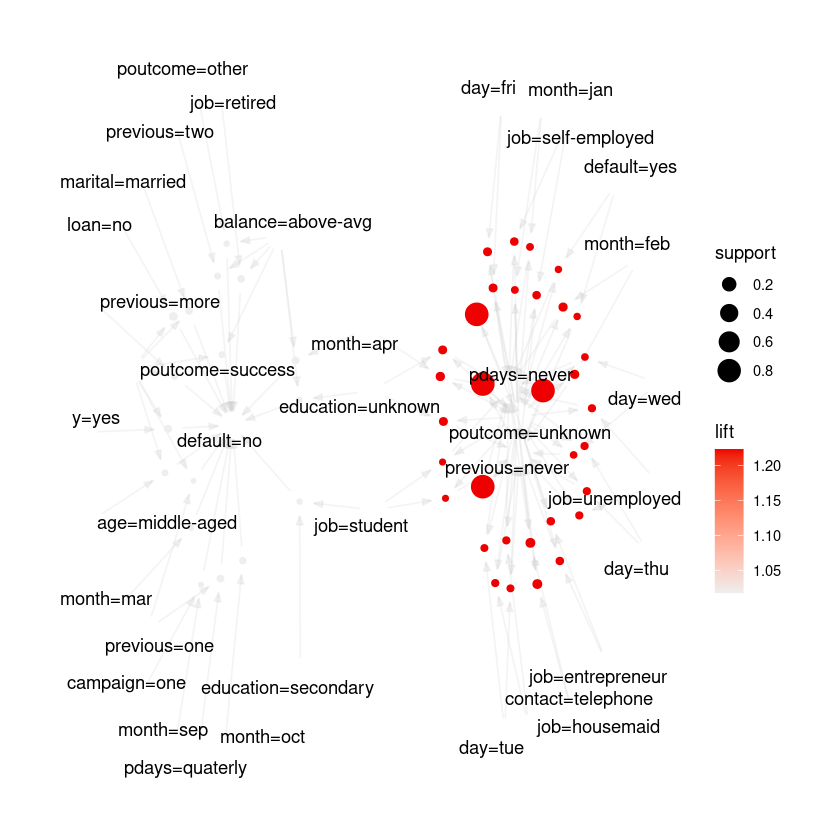

In [98]:
plot(rulesPruned[1:50], method="graph")

A continuación, vemos el número de items que forman el antecedente y el consecuente del conjunto de reglas de asociación. Podemos destacar varios grupos de valores principales:
* Cuando se comunican de forma previa dos veces, el resultado es negativo.
* Cuando la duración de la llamada se alarga más de cinco minutos se contrata el producto.

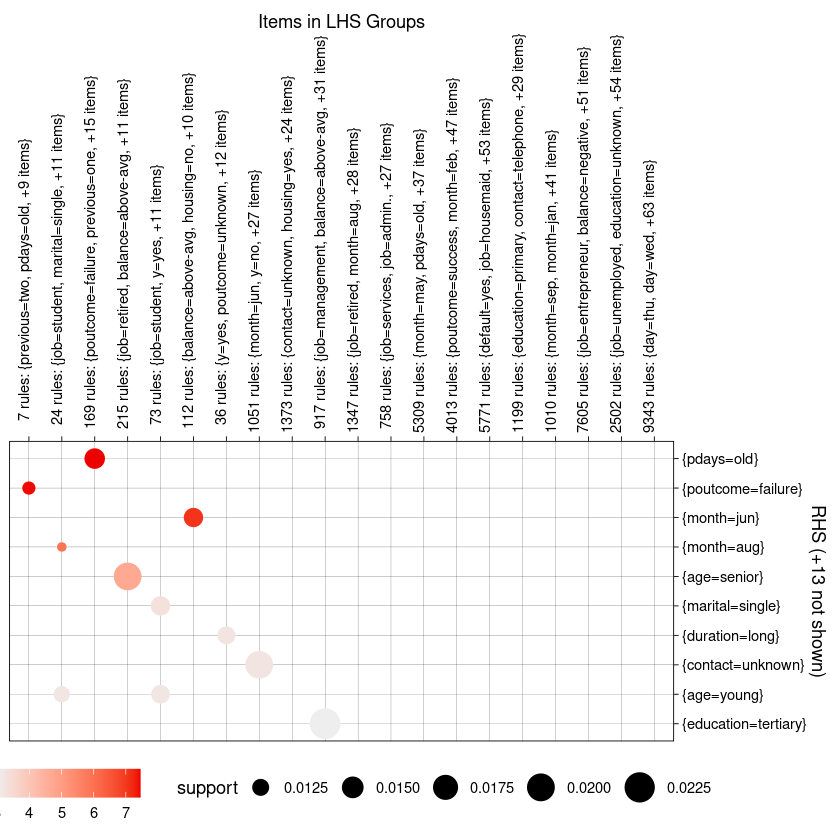

In [91]:
plot(rulesPruned, method="grouped")

Por último vemos que reglas con pocos valores en el antecesor forman los principales consecuentes a través de un gráfico de coordenadas paralelas. El gráfico de abajo no nos muestra gran información ya que apuntan a los consecuentes más generales.

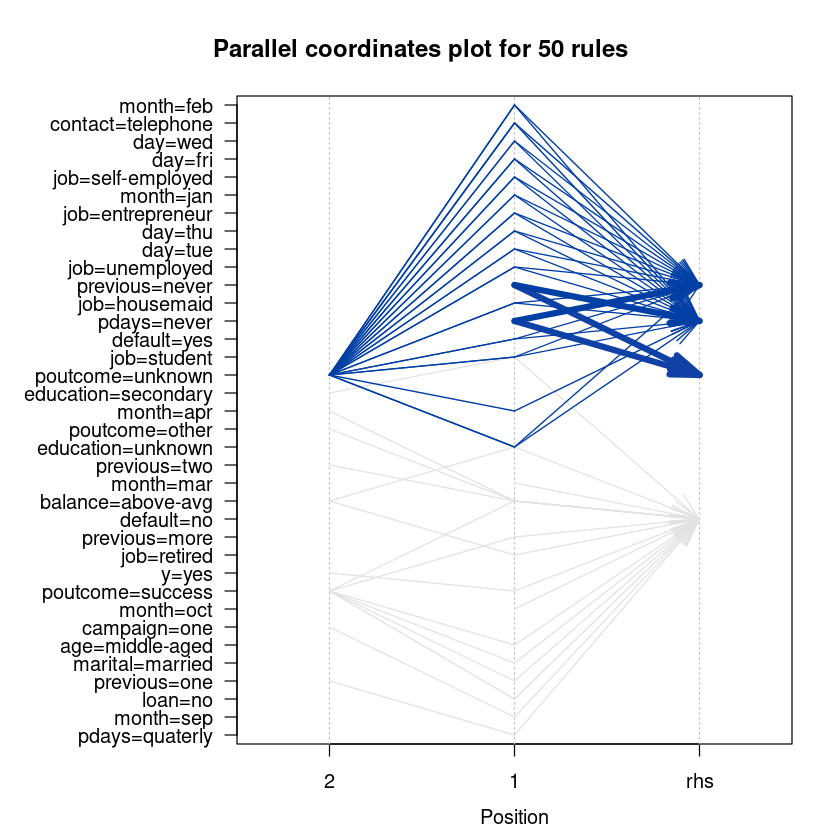

In [97]:
plot(rulesPruned[1:50], method="paracoord", reorder=TRUE,
control=list(col=sequential_hcl(100)))

## Estudio de reglas por grupos

Estudiamos la relación entre estar casado y tener una hipoteca (o no tenerla). Los clientes que están casados y tienen una hipoteca cumplen con el siguiente perfil: pertenecen a la población con la edad media, forman la parte más baja de la jerarquía de las empresas (blue-collar), y solo se realizó un intento para ofrecerles la campaña. Este grupo fue contactado de forma principal en mayo.

In [117]:
rulesMaritalHousing <- subset(rulesPruned, subset = lhs %in% "marital=married" & rhs %in% "housing=yes")
inspect(head(rulesMaritalHousing))

    lhs                     rhs              support confidence   coverage     lift count
[1] {age=middle-aged,                                                                    
     job=blue-collar,                                                                    
     marital=married,                                                                    
     education=primary,                                                                  
     month=may,                                                                          
     campaign=one,                                                                       
     y=no}               => {housing=yes} 0.01081595  0.9625984 0.01123620 1.731796   489
[2] {age=middle-aged,                                                                    
     job=blue-collar,                                                                    
     marital=married,                                                                    
     educa

Para los clientes que están casados y no tienen una hipoteca establecemos el siguiente perfil: son clientes senior, que no tienen préstamos, con un sueldo por debajo de la media (por lógica intuimos que muchos estan jubilados). Este grupo vemos que fue contactado en agosto y que en la mayoría de casos nunca se había contactado con ellos de forma previa.

In [111]:
rulesMaritalHousing <- subset(rulesPruned, subset = lhs %in% "marital=married" & rhs %in% "housing=no")
inspect(head(rulesMaritalHousing))

    lhs                     rhs             support confidence   coverage     lift count
[1] {age=senior,                                                                        
     marital=married,                                                                   
     balance=below-avg,                                                                 
     loan=no,                                                                           
     month=aug,                                                                         
     pdays=never}        => {housing=no} 0.01265179  0.9270665 0.01364712 2.087227   572
[2] {age=senior,                                                                        
     marital=married,                                                                   
     balance=below-avg,                                                                 
     loan=no,                                                                           
     month=aug,      

Por último comprobamos la excepción de que un cliente esté casado, no tenga crédito en default y no tenga una hipoteca. Vemos que la mayoría de estos casos es el perfil del clientes jubilados que no tienen crédito en default ni préstamos.

In [118]:
rulesMaritalHousing <- subset(rulesPruned, subset = lhs %ain% c("marital=married","default=no") & rhs %in% "housing=no")
inspect(head(rulesMaritalHousing))

    lhs                    rhs             support confidence   coverage     lift count
[1] {age=senior,                                                                       
     job=retired,                                                                      
     marital=married,                                                                  
     default=no,                                                                       
     loan=no,                                                                          
     contact=cellular,                                                                 
     pdays=never}       => {housing=no} 0.01234213  0.8913738 0.01384619 2.006867   558
[2] {age=senior,                                                                       
     job=retired,                                                                      
     marital=married,                                                                  
     default=no,                

Por otro lado, estudiamos la relación entre ser joven (< 33 años) y tener una hipoteca. Los clientes que son jóvenes y tienen una hipoteca cumplen con el siguiente perfil: forman la parte más baja de la jerarquía de las empresas (blue-collar), no tienen crédito en default, están casados y en la mayoría de casos se contactó solo una vez. Para estos clientes la campaña se llevó a cabo en mayo.

In [115]:
rulesAgeHousing <- subset(rulesPruned, subset = lhs %in% "age=young" & rhs %in% "housing=yes")
inspect(head(rulesAgeHousing, n=10))

     lhs                     rhs              support confidence   coverage     lift count
[1]  {age=young,                                                                          
      job=blue-collar,                                                                    
      marital=married,                                                                    
      default=no,                                                                         
      balance=below-avg,                                                                  
      month=may}          => {housing=yes} 0.01072748  0.9454191 0.01134680 1.700889   485
[2]  {age=young,                                                                          
      job=blue-collar,                                                                    
      marital=married,                                                                    
      contact=unknown,                                                                    

Para los clientes jóvenes que no tienen una hipoteca establecemos el siguiente perfil: son clientes solteros, que no tienen crédito en default y nunca habían sido contactados en otra ocasión. La campaña se llevó a cabo para este grupo de clientes en agosto.

In [119]:
rulesAgeHousing <- subset(rulesPruned, subset = lhs %in% "age=young" & rhs %in% "housing=no")
inspect(head(rulesAgeHousing))

    lhs                   rhs             support confidence   coverage     lift count
[1] {age=young,                                                                       
     marital=single,                                                                  
     loan=no,                                                                         
     month=aug,                                                                       
     pdays=never}      => {housing=no} 0.01331534  0.8699422 0.01530601 1.958615   602
[2] {age=young,                                                                       
     marital=single,                                                                  
     loan=no,                                                                         
     month=aug,                                                                       
     previous=never}   => {housing=no} 0.01331534  0.8699422 0.01530601 1.958615   602
[3] {age=young,                            

## Estudio de reglas negadas

Observamos como afecta la duración de la llamada al cliente. Para el estudio de reglas negadas es necesario bajar la confianza de 0.9 para no obtener reglas obvias.

Para la duración superior a cinco minutos, obtenemos que son clientes jóvenes, solteros, que fueron contactados solo una vez y con un balance por debajo de la media.

In [143]:
rulesLongDur <- subset(rulesPruned, subset = lhs %in% "duration=long" & confidence < 0.9)
inspect(head(rulesLongDur))

    lhs                     rhs                   support confidence   coverage     lift count
[1] {age=young,                                                                               
     contact=unknown,                                                                         
     duration=long,                                                                           
     campaign=one}       => {housing=yes}      0.01470881  0.8998647 0.01634558 1.618933   665
[2] {marital=single,                                                                          
     balance=below-avg,                                                                       
     housing=no,                                                                              
     duration=long,                                                                           
     y=no}               => {pdays=never}      0.01232001  0.8998384 0.01369136 1.100898   557
[3] {marital=single,                              

Por otra parte, los clientes que fueron contactados menos de cinco minutos trabajaban en la administración, no tenian deudas ni hipotecas y en su mayor parte la duración fue menos de dos minutos.

In [146]:
rulesLongDur <- subset(rulesPruned, subset = lhs %in% c("duration=quick","duration=regular") & confidence < 0.9)
inspect(head(rulesLongDur))

    lhs                       rhs                   support confidence   coverage     lift count
[1] {job=management,                                                                            
     default=no,                                                                                
     housing=no,                                                                                
     duration=quick}       => {pdays=never}      0.03061202  0.8998700 0.03401827 1.100937  1384
[2] {job=management,                                                                            
     default=no,                                                                                
     housing=no,                                                                                
     duration=quick}       => {previous=never}   0.03061202  0.8998700 0.03401827 1.100937  1384
[3] {job=management,                                                                            
     default=no,              